In [13]:
# %%
# Queries database to get data with our without dates

import pandas as pd
import numpy as np
import geopandas as gpd
from sqlalchemy import create_engine, text

import mpl_toolkits.mplot3d

#query db, return array
def query_db(include_weights=False):
    engine = create_engine("sqlite:///updated_fires_db.sqlite")

    # NWCG_REPORTING_AGENCY
    # FIRE_YEAR
    # DISCOVERY_DATE
    # DISCOVERY_DOY
    # DISCOVERY_TIME
    # NWCG_CAUSE_CLASSIFICATION
    # NWCG_GENERAL_CAUSE
    # FIRE_SIZE
    # FIRE_SIZE_CLASS
    # LATITUDE
    # LONGITUDE
    # STATE
    # COUNTY

    query = ' ' 
    #'''
    #    SELECT REAL_LATITUDE, REAL_LONGITUDE, REAL_DISCOVERY_DOY, REAL_FIRE_SIZE FROM Fires 
    #    LIMIT 5000
    #'''
    
    with engine.connect() as connection:
        result = connection.execute(text(
        query
            )
        )

        # Gets all column names
        table_query = "PRAGMA table_info(Fires);"
        existing_columns = [] # list of all colmns in the fire table
        result = connection.execute(text(table_query))
        data = []
        for row in result:
            a = []
            for item in row:
                a.append(item)

            data.append(a)
        # print(data)
        column_infos = np.array(data)

        # For each column we get several parts of info that we must proccess
        for column_info in column_infos:
            
            column_info_parts = str(column_info).split(" ") # seperate all these parts into individual pieces
            existing_columns.append(column_info_parts[1].strip("'")) # remove quotes from the column name part and add it

        #print(str(existing_columns))
        used_columns=[]
        # DOY must be the first column to be inversly joined against
        used_columns.extend(["Fires.REAL_DISCOVERY_DOY", "Fires.REAL_LATITUDE", "Fires.REAL_LONGITUDE", "Fires.REAL_FIRE_SIZE", "Fires.REAL_FIRE_YEAR"])
        query = "SELECT " # "REAL_" columns need to be added manually as they are what we use to display and order matters 

        # Adds the explicit "REAL_" columns to the query
        first_col = True
        for col in used_columns:
            # only adds commas after the first col
            if(not first_col):
                query += ", "
            query += col
            first_col = False
            
        # Add all columns to list of things to group on
        for col_name in existing_columns:
            if(col_name != 'OBJECTID' and 'STATE_' not in col_name and (col_name.startswith("AGENCY_") or col_name.startswith("CAUSE_"))): # Dont group on the primary key OBJECTID
                query += ", "  + col_name
                used_columns.append("Fires."+col_name)

        # Gets the weights from the fire
        if(include_weights):
            query += ", Calendar.Date_weight"
            used_columns.append("Calendar.Date_weight")
        query += " FROM Fires"

        # Joins fires with the calendear to map weights 
        if(include_weights):
            query += " JOIN Calendar ON Fires.DISCOVERY_DOY = Calendar.DOY AND Fires.FIRE_YEAR = Calendar.Year"
        # Removes any data we do not know the cause of
        query += " WHERE NWCG_GENERAL_CAUSE != 'Missing data/not specified/undetermined'"

        #query += " LIMIT 5000"
        query += ";"

        print("query: " + query)

        """
        result = connection.execute(text(query))
        
        data = []
        for row in result:
            a = []
            for item in row:
                a.append(item)

            data.append(a)
            # print(data)
        clean_data = np.array(data)
        """
if(include_weights):
            query = "SELECT Fires.*, Calendar.Date_weight FROM FIRES JOIN Calendar ON Fires.DISCOVERY_DOY = Calendar.DOY AND Fires.FIRE_YEAR = Calendar.Year WHERE Fires.NWCG_GENERAL_CAUSE != 'Missing data/not specified/undetermined'"
            existing_columns.append("Calendar.Date_weight")
        else:
            query = "SELECT * FROM FIRES WHERE Fires.NWCG_GENERAL_CAUSE != 'Missing data/not specified/undetermined'"
        result = connection.execute(text(query))
        
        data = []
        for row in result:
            a = []
            for item in row:
                a.append(item)

            data.append(a)
            # print(data)
        raw_data = np.array(data)
        #print(x)
    return raw_data, clean_data, existing_columns #used_columns]

# %%


In [ ]:
data, cleaned_data, column_headers = query_db(False, )


query: SELECT Fires.REAL_DISCOVERY_DOY, Fires.REAL_LATITUDE, Fires.REAL_LONGITUDE, Fires.REAL_FIRE_SIZE, Fires.REAL_FIRE_YEAR, AGENCY_FS, AGENCY_BIA, AGENCY_TRIBE, AGENCY_BLM, AGENCY_NPS, AGENCY_BOR, AGENCY_FWS, AGENCY_ST_C_L, AGENCY_DOD, AGENCY_IA, AGENCY_DOE, CAUSE_POWER_GENERATION_TRANSMISSION_DISTRIBUTION, CAUSE_NATURAL, CAUSE_DEBRIS_AND_OPEN_BURNING, CAUSE_MISSING_DATA_NOT_SPECIFIED_UNDETERMINED, CAUSE_RECREATION_AND_CEREMONY, CAUSE_EQUIPMENT_AND_VEHICLE_USE, CAUSE_ARSON_INCENDIARISM, CAUSE_FIREWORKS, CAUSE_OTHER_CAUSES, CAUSE_RAILROAD_OPERATIONS_AND_MAINTENANCE, CAUSE_SMOKING, CAUSE_MISUSE_OF_FIRE_BY_A_MINOR, CAUSE_FIREARMS_AND_EXPLOSIVES_USE FROM Fires WHERE NWCG_GENERAL_CAUSE != 'Missing data/not specified/undetermined';


In [ ]:
# Henry Code Usage
import read

#data, cleaned_data, column_headers = query_db(False)
read.doKmean(data, cleaned_data, column_headers, "Non-weighted Query")
#print(read.MODIFIED_DB)

In [7]:
# DO K-means for weighted and non-weighted data

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

import mpl_toolkits.mplot3d
import numpy as np

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Stores the outputs of the kmeans calculations so they can be used in future runs 
non_weighted_kmeans = []
weighted_kmeans = []
non_weighted_data = None
weighted_data = None
non_weighted_used_columns = []
weighted_used_columns = []

def run(use_weights=False):
    global non_weighted_used_columns
    global weighted_used_columns
    
    query_out = query_db(use_weights)
    data = query_out[0]
    
    # Records which columns are being used for display purposes
    if(use_weights):
        weighted_used_columns = query_out[1]
    else:
        non_weighted_used_columns = query_out[1]
        
    
    do_kmean(data, use_weights)
    

def do_kmean(data, use_weights=False):
    global non_weighted_kmeans
    global weighted_kmeans
    global non_weighted_data
    global weighted_data
    
    kmeans = KMeans(n_clusters=8, random_state=0, n_init="auto").fit(data)
    
    if(use_weights):
        weighted_data = data
    else:
        non_weighted_data = data
    y = kmeans.labels_

    # Definition of enumerators runs the kmeans algos
    if(use_weights):
        weighted_kmeans = [
            ("k_means_iris_8", KMeans(n_clusters=8, custom=True, alpha=1, dimensions=2)),
            ("k_means_iris_3", KMeans(n_clusters=3, custom=True, alpha=1, dimensions=2)),
            ("k_means_iris_20", KMeans(n_clusters=20, custom=True, alpha=1, dimensions=2))
        ]
    # Gets the data without weights
    else:
        non_weighted_kmeans = [
            ("k_means_iris_8", KMeans(n_clusters=8, custom=False, alpha=1, dimensions=2)),
            ("k_means_iris_3", KMeans(n_clusters=3, custom=False, alpha=1, dimensions=2)),
            ("k_means_iris_20", KMeans(n_clusters=20, custom=False, alpha=1, dimensions=2))
        ]



#run(True)
#data = query_db()
#print(data)

In [32]:
# Calculates non-weighted kmeans outputs
run(False) # Gets unweighted kmeans values

query: SELECT Fires.REAL_DISCOVERY_DOY, Fires.REAL_LATITUDE, Fires.REAL_LONGITUDE, Fires.REAL_FIRE_SIZE, Fires.REAL_FIRE_YEAR, AGENCY_FS, AGENCY_BIA, AGENCY_TRIBE, AGENCY_BLM, AGENCY_NPS, AGENCY_BOR, AGENCY_FWS, AGENCY_ST_C_L, AGENCY_DOD, AGENCY_IA, AGENCY_DOE, CAUSE_POWER_GENERATION_TRANSMISSION_DISTRIBUTION, CAUSE_NATURAL, CAUSE_DEBRIS_AND_OPEN_BURNING, CAUSE_MISSING_DATA_NOT_SPECIFIED_UNDETERMINED, CAUSE_RECREATION_AND_CEREMONY, CAUSE_EQUIPMENT_AND_VEHICLE_USE, CAUSE_ARSON_INCENDIARISM, CAUSE_FIREWORKS, CAUSE_OTHER_CAUSES, CAUSE_RAILROAD_OPERATIONS_AND_MAINTENANCE, CAUSE_SMOKING, CAUSE_MISUSE_OF_FIRE_BY_A_MINOR, CAUSE_FIREARMS_AND_EXPLOSIVES_USE FROM Fires WHERE NWCG_GENERAL_CAUSE != 'Missing data/not specified/undetermined';


In [8]:
# Calcculates weighted kmeans outputs
run(True) # Gets weighted kmeans values

query: SELECT Fires.REAL_DISCOVERY_DOY, Fires.REAL_LATITUDE, Fires.REAL_LONGITUDE, Fires.REAL_FIRE_SIZE, Fires.REAL_FIRE_YEAR, AGENCY_FS, AGENCY_BIA, AGENCY_TRIBE, AGENCY_BLM, AGENCY_NPS, AGENCY_BOR, AGENCY_FWS, AGENCY_ST_C_L, AGENCY_DOD, AGENCY_IA, AGENCY_DOE, CAUSE_POWER_GENERATION_TRANSMISSION_DISTRIBUTION, CAUSE_NATURAL, CAUSE_DEBRIS_AND_OPEN_BURNING, CAUSE_MISSING_DATA_NOT_SPECIFIED_UNDETERMINED, CAUSE_RECREATION_AND_CEREMONY, CAUSE_EQUIPMENT_AND_VEHICLE_USE, CAUSE_ARSON_INCENDIARISM, CAUSE_FIREWORKS, CAUSE_OTHER_CAUSES, CAUSE_RAILROAD_OPERATIONS_AND_MAINTENANCE, CAUSE_SMOKING, CAUSE_MISUSE_OF_FIRE_BY_A_MINOR, CAUSE_FIREARMS_AND_EXPLOSIVES_USE, Calendar.Date_weight FROM Fires JOIN Calendar ON Fires.DISCOVERY_DOY = Calendar.DOY AND Fires.FIRE_YEAR = Calendar.Year WHERE NWCG_GENERAL_CAUSE != 'Missing data/not specified/undetermined';


In [3]:
# CREATES DIAGRAMS WITH KMEAN RESULTS

def create_diagrams(estimators, data, used_columns, save_output = False):
    '''
    fig = plt.figure(figsize=(20, 16))
    titles = ["8 clusters", "3 clusters", "20 clusters"]
    for idx, ((name, est), title) in enumerate(zip(estimators, titles)):
        ax = fig.add_subplot(2, 2, idx + 1, projection="3d", elev=48, azim=134)
        est.fit(data)
        labels = est.labels_

        ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels.astype(float), edgecolor="k")

        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        ax.zaxis.set_ticklabels([])
        ax.set_xlabel("Long")
        ax.set_ylabel("Lat")
        ax.invert_yaxis()
        ax.set_zlabel("DOY")
        ax.set_title(title)
            
        
    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    plt.show()
    ''' 
    
    print("estimator 0 " + str(estimators[0]))
    if True: #for (name, est) in estimators[0][1]:
        plt.figure(figsize=(20, 8))
        title = "8 clusters"
        # Print out the value of the clusters for the 8 cluster example
        if(title == "8 clusters"):
            #clusterDiagram = fig.add_subplot() # create a new subplot for info about the clusters

            clusterID = 1 # identify each cluster 
            for cluster in estimators[0][1].cluster_centers_: # get cluster centers to represent the cluster
                #print("Cluster " + str(clusterID) + " :")
                #for val_index in range(0,len(cluster)): # displays all the clusters values for each column
                    #print(str(used_columns[val_index]) + ": " + str(cluster[val_index]))
                
                # plot the current clusters values in the diagram
                plt.plot(used_columns, cluster, label = "Cluster " + str(clusterID))
                clusterID = clusterID + 1

            plt.xticks(rotation=90)
            plt.legend()

    if(save_output):
        plt.savefig("figures/cluster_8_chart.png")
    else:
        plt.show()


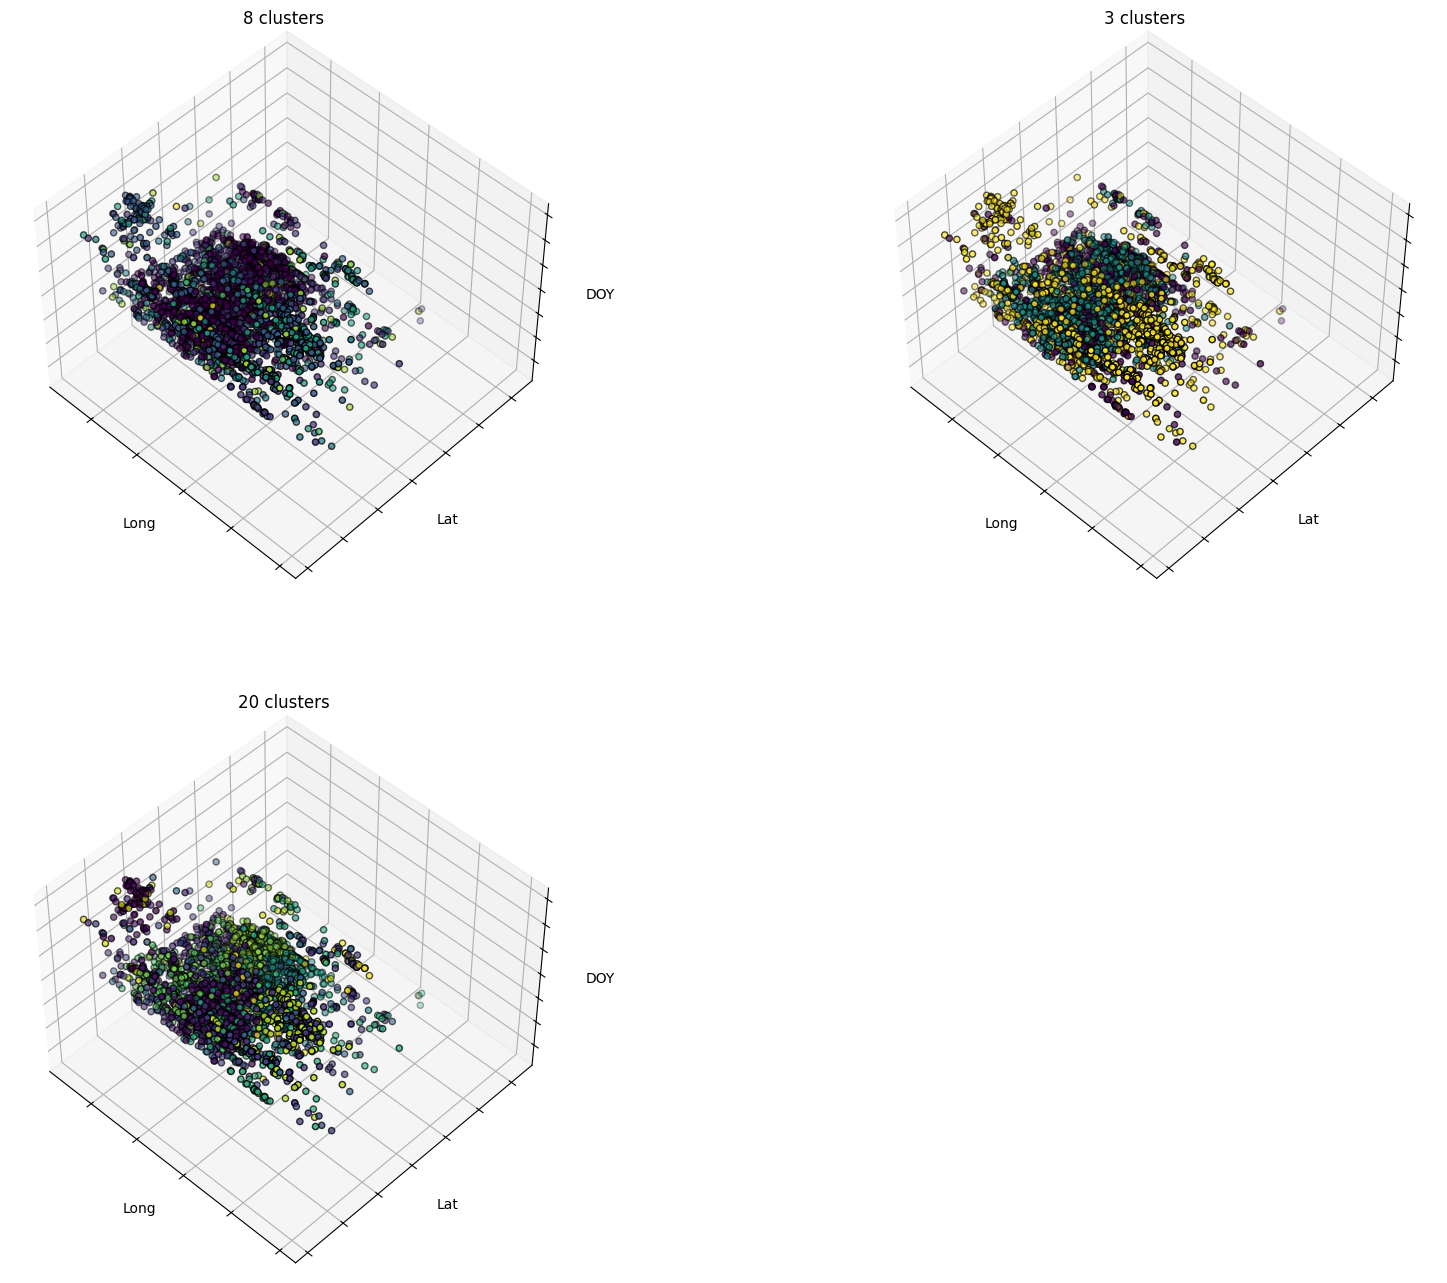

estimator 0 ('k_means_iris_8', KMeans(alpha=(1,), custom=(True,)))


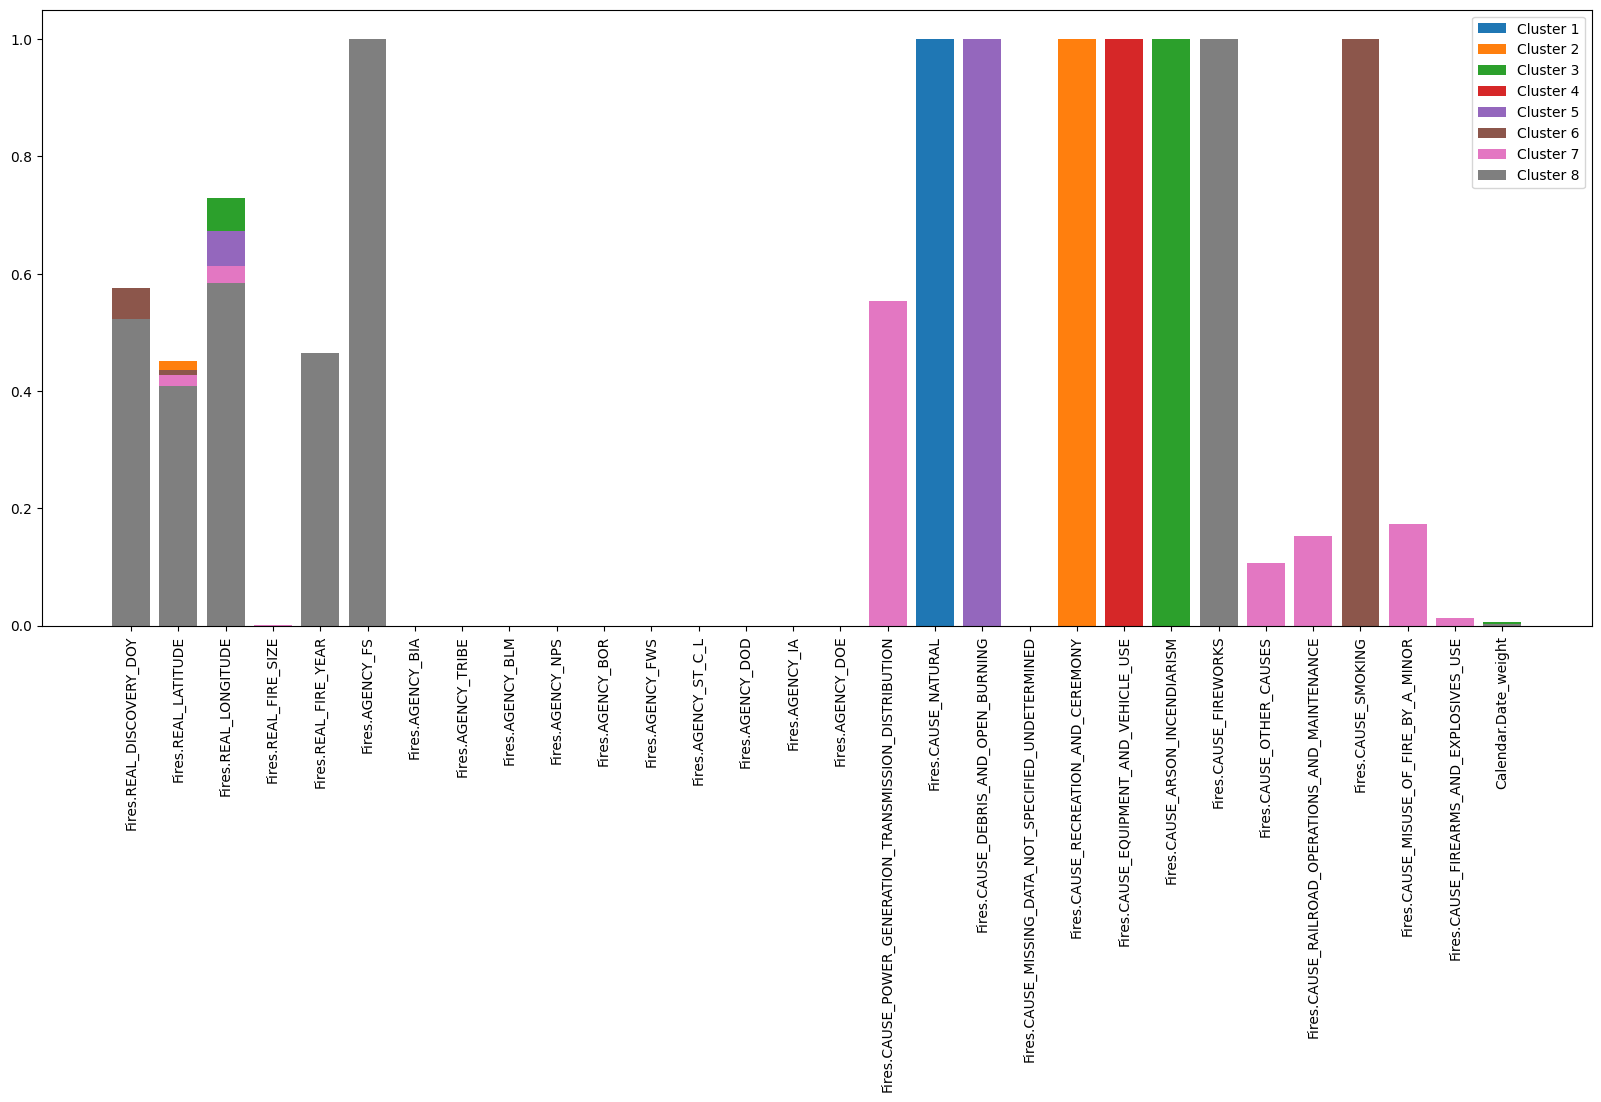

In [29]:
create_diagrams(weighted_kmeans, weighted_data, weighted_used_columns) #put either non_weighted_kmeans or weighted_kmeans based on what you did previously

In [4]:
create_diagrams(non_weighted_kmeans, non_weighted_data, non_weighted_used_columns, True) # Diagram non_weighted_kmeans 

NameError: name 'non_weighted_kmeans' is not defined

In [ ]:
# OTHER TESTING SCRIPTS, CAN BE IGNORED #

#import pandas as pd
import numpy as np
#import geopandas as gpd
#import matplotlib.pyplot as plt
#from shapely.geometry import Point, Polygon
from sqlalchemy import create_engine, text

#import mpl_toolkits.mplot3d
import numpy as np

def test_values_db():
    engine = create_engine("sqlite:///updated_fires_db.sqlite")

    # NWCG_REPORTING_AGENCY
    # FIRE_YEAR
    # DISCOVERY_DATE
    # DISCOVERY_DOY
    # DISCOVERY_TIME
    # NWCG_CAUSE_CLASSIFICATION
    # NWCG_GENERAL_CAUSE
    # FIRE_SIZE
    # FIRE_SIZE_CLASS
    # LATITUDE
    # LONGITUDE
    # STATE
    # COUNTY

    query = '''
        SELECT REAL_LATITUDE, REAL_LONGITUDE, REAL_DISCOVERY_DOY, REAL_FIRE_SIZE, CAUSE_NATURAL, CAUSE_FIREWORKS FROM Fires 
    '''
    query = "SELECT * from CALENDAR LIMIT 366"
    with engine.connect() as connection:
        result = connection.execute(text(query))
        data = []
        for row in result:
            a = []
            for item in row:
                a.append(item)

            data.append(a)
        # print(data)
        result = np.array(data)
        for row in result:
            print(row)
        '''
        lat = []
        long = []
        doy = []
        size = []
        c_nat = []
        c_fireworks = []
        for res in result:
            lat.append(res[0])
            long.append(res[1])
            doy.append(res[2])
            size.append(res[3])
            c_nat.append(res[4])
            c_fireworks.append(res[5])

        print("lat avg: " + str(sum(lat)/len(lat)))
        print("long avg: " + str(sum(long)/len(long)))
        print("doy avg: " + str(sum(doy)/len(doy)))
        print("size avg: " + str(sum(size)/len(size)))
        print("cause natural avg: " + str(sum(c_nat)/len(c_nat)))
        print("cuase natrural max: " + str(max(c_nat)))
        print("cause c_fireworks avg: " + str(sum(c_fireworks)/len(c_fireworks)))
        print("cuase c_fireworks max: " + str(max(c_fireworks)))
        '''
test_values_db()

In [ ]:
rows = query_db(True)
for row in rows:
    print(row)